In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import AdaBoostClassifier
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
import winsound as sound

# Read CSV file.

In [3]:
# Read CSV into pandas dataframe.
df = pd.read_csv('./telcochurn.csv')

# Preprocessing.

In [4]:
# Drop customerID.
df.drop(['customerID'], axis=1, inplace=True)

In [5]:
# Convert TotalCharges column to numeric values, set unconvertible columns to null.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with null values in any column.
df.dropna(inplace=True)

## Scale numerical columns.

In [6]:
# List of every numerical column.
tenure_list = df['tenure'].values.astype('int').tolist()
monthly_charges_list = df['MonthlyCharges'].values.astype('float').tolist()
total_charges_list = df['TotalCharges'].values.astype('float').tolist()

# Apply sklearn's MixMaxScaler to each list.
scaler = MinMaxScaler()

# Create scaled data lists.
scaled_tenure = scaler.fit_transform(np.reshape(tenure_list, (-1,1)))
scaled_monthly_charges = scaler.fit_transform(np.reshape(monthly_charges_list, (-1,1)))
scaled_total_charges = scaler.fit_transform(np.reshape(total_charges_list, (-1,1)))

# Add scaled columns to dataframe.
df['scaled_tenure'] = scaled_tenure
df['scaled_monthly_charges'] = scaled_monthly_charges
df['scaled_total_charges'] = scaled_total_charges

# Drop unscaled columns.
df.drop(['tenure', 'MonthlyCharges', 'TotalCharges'], axis=1, inplace=True)

C:\Users\Akshat\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


## Create new join indicator column 'churned'.

In [7]:
df['churned'] = [1 if x == 'Yes' else 0 for x in df['Churn']]

In [8]:
# Drop original indicator column.
df.drop(['Churn'], axis=1, inplace=True)

## Cut down non-join data rows until equality between join and non-join.

In [9]:
# Find all join rows.
joined_df = df.loc[df['churned'] == 1]

# Calculate number of joins.
num_positive = joined_df.shape[0]

# Take random sample of non-join rows.
non_joined_sample_df = df.loc[df['churned'] == 0].sample(n=num_positive)

# Create dataframe of chosen rows.
equal_split_df = joined_df.append(non_joined_sample_df)

## Split data into training, testing, and validation datasets.

In [10]:
# Split data into IVs and DV.
X = equal_split_df.drop('churned', axis=1)
y = equal_split_df['churned'].values

In [11]:
X_dummy = pd.get_dummies(X)

In [12]:
# Split the data into three categories: training data, testing data, and validation data.
X_train_test, X_validation, y_train_test, y_validation = train_test_split(X_dummy, y, test_size = .2, random_state = 99)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size = .25, random_state = 99)

# Logistic Regression model.

In [13]:
# Create Logistic Regression model, fit the model to the training data.
model = LogisticRegression(random_state = 99, solver='liblinear')
model = model.fit(X_train, y_train)

In [14]:
# Get predictions for the testing data.
test_preds = model.predict(X_test)

# Get predictions for the validation data.
valid_preds = model.predict(X_validation)

# Plot descriptive graphs and statistics.

### General statistics (Accuracy, Precision, Recall, F1 Score).

In [15]:
# Useful statistics
test_accuracy = metrics.accuracy_score(y_test, test_preds)
test_precision = metrics.precision_score(y_test, test_preds)
test_recall = metrics.recall_score(y_test, test_preds)
test_f1_score = metrics.f1_score(y_test, test_preds)

test_stats_list = [test_accuracy, test_precision, test_recall, test_f1_score]

In [16]:
# Useful statistics
valid_accuracy = metrics.accuracy_score(y_validation, valid_preds)
valid_precision = metrics.precision_score(y_validation, valid_preds)
valid_recall = metrics.recall_score(y_validation, valid_preds)
valid_f1_score = metrics.f1_score(y_validation, valid_preds)

valid_stats_list = [valid_accuracy, valid_precision, valid_recall, valid_f1_score]

In [17]:
stat_names_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Dataframe for all statistics.
stats_df = pd.DataFrame()
stats_df['Statistic'] = stat_names_list
stats_df['Test dataset value'] = test_stats_list
stats_df['Validation dataset value'] = valid_stats_list

### Confusion Matrices.

In [18]:
test_cm = metrics.confusion_matrix(y_test, test_preds)
valid_cm = metrics.confusion_matrix(y_validation, valid_preds)

### Receiver Operating Characteristics.

In [19]:
# Test dataset.
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, test_preds)
test_auc = metrics.auc(test_fpr, test_tpr)

In [20]:
# Validation dataset.
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_validation, valid_preds)
valid_auc = metrics.auc(valid_fpr, valid_tpr)

### Precision-Recall curves.

In [21]:
# Get churned probability on test predictions.
test_probs_rows = model.predict_proba(X_test)
test_probs = [test_probs_rows[i][1] for i in range(len(test_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
test_prec, test_rec, test_thresholds = metrics.precision_recall_curve(y_test, test_probs)

In [22]:
# Get churned probability on validation predictions.
valid_probs_rows = model.predict_proba(X_validation)
valid_probs = [valid_probs_rows[i][1] for i in range(len(valid_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
valid_prec, valid_rec, valid_thresholds = metrics.precision_recall_curve(y_validation, valid_probs)

## Plot graphs and statistics.

In [23]:
# Set dataframe print properties.
heading_properties = [('font-size', '28px')]
cell_properties = [('font-size', '28px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [24]:
# Set the tickmark names.
classNames = ['Not Joined','Joined']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

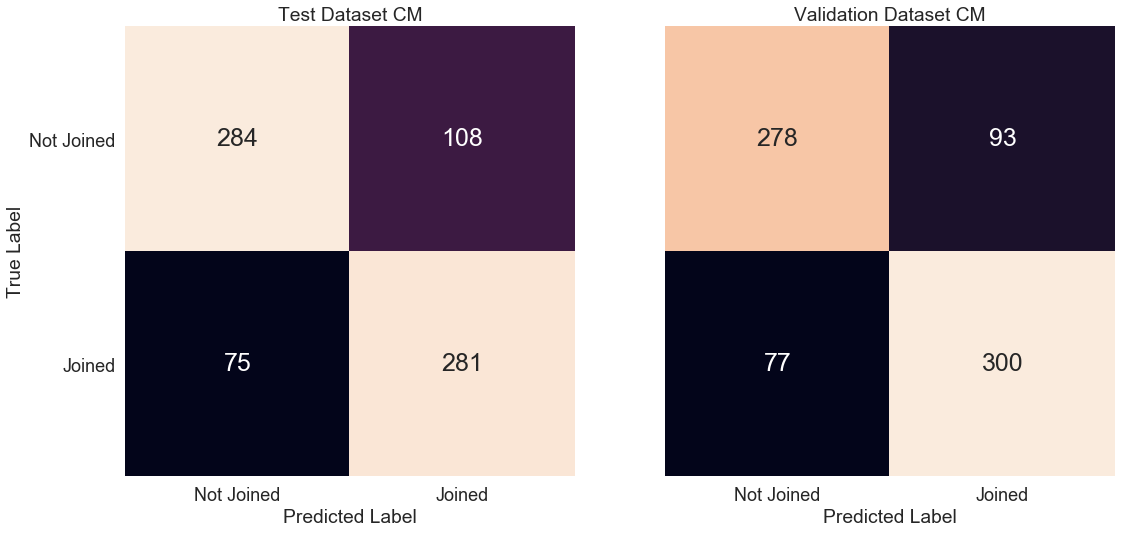

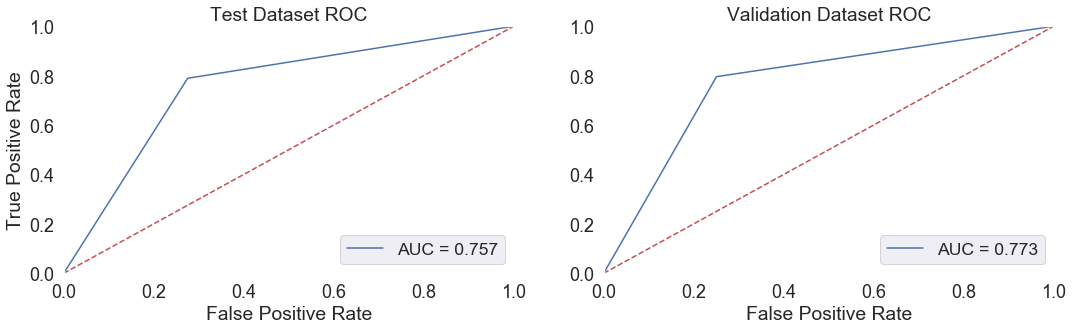

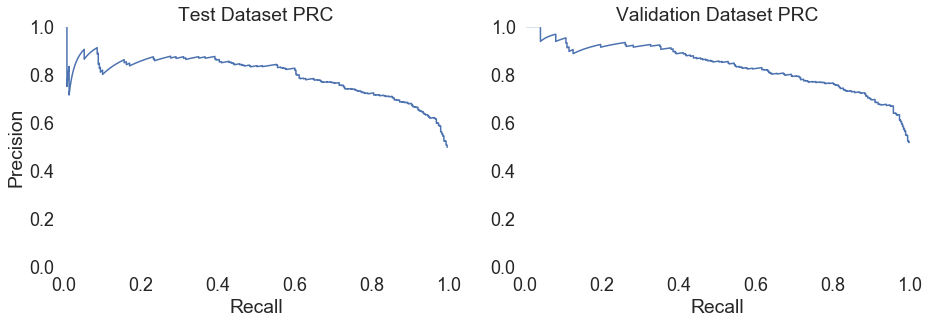

,Statistic,Test dataset value,Validation dataset value
0,Accuracy,0.755348,0.772727
1,Precision,0.722365,0.763359
2,Recall,0.789326,0.795756
3,F1 Score,0.754362,0.779221


In [25]:
# Set confusion matrices' figure and text size.
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 25, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test Dataset.
#==========================================
# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#==========================================

# Validation Dataset.
#==========================================
# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=[], square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set plot and text sizes.
plt.figure(figsize=(10,10))
plt.rcParams.update({'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test ROC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(2,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#==========================================

# Validation ROC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(2,2,2, fc='white')

# Set title.
plt.title('Validation Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set PRC figure and text sizes.
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test PRC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(3,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset PRC')

# Plot the precision-recall curve.
plt.plot(test_rec, test_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('Precision')
plt.xlabel('Recall')
#==========================================

# Validation PRC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(3,2,2, fc='white')

# Set title.
plt.title('Validation Dataset PRC')

# Plot the precision-recall curve.
plt.plot(valid_rec, valid_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('Recall')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()
#==========================================

# Print statistics.
stats_df.style.set_table_styles(dfstyle)

# AdaBoost model.

In [26]:
# Create Adaboost model, fit the model to the training data.
model = AdaBoostClassifier(random_state = 99)
model = model.fit(X_train, y_train)

In [27]:
# Get predictions for the testing data.
test_preds = model.predict(X_test)

# Get predictions for the validation data.
valid_preds = model.predict(X_validation)

# Plot descriptive graphs and statistics.

### General statistics (Accuracy, Precision, Recall, F1 Score).

In [28]:
# Useful statistics
test_accuracy = metrics.accuracy_score(y_test, test_preds)
test_precision = metrics.precision_score(y_test, test_preds)
test_recall = metrics.recall_score(y_test, test_preds)
test_f1_score = metrics.f1_score(y_test, test_preds)

test_stats_list = [test_accuracy, test_precision, test_recall, test_f1_score]

In [29]:
# Useful statistics
valid_accuracy = metrics.accuracy_score(y_validation, valid_preds)
valid_precision = metrics.precision_score(y_validation, valid_preds)
valid_recall = metrics.recall_score(y_validation, valid_preds)
valid_f1_score = metrics.f1_score(y_validation, valid_preds)

valid_stats_list = [valid_accuracy, valid_precision, valid_recall, valid_f1_score]

In [30]:
stat_names_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Dataframe for all statistics.
stats_df = pd.DataFrame()
stats_df['Statistic'] = stat_names_list
stats_df['Test dataset value'] = test_stats_list
stats_df['Validation dataset value'] = valid_stats_list

### Confusion Matrices.

In [31]:
test_cm = metrics.confusion_matrix(y_test, test_preds)
valid_cm = metrics.confusion_matrix(y_validation, valid_preds)

### Receiver Operating Characteristics.

In [32]:
# Test dataset.
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, test_preds)
test_auc = metrics.auc(test_fpr, test_tpr)

In [33]:
# Validation dataset.
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_validation, valid_preds)
valid_auc = metrics.auc(valid_fpr, valid_tpr)

### Precision-Recall curves.

In [34]:
# Get churned probability on test predictions.
test_probs_rows = model.predict_proba(X_test)
test_probs = [test_probs_rows[i][1] for i in range(len(test_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
test_prec, test_rec, test_thresholds = metrics.precision_recall_curve(y_test, test_probs)

In [35]:
# Get churned probability on validation predictions.
valid_probs_rows = model.predict_proba(X_validation)
valid_probs = [valid_probs_rows[i][1] for i in range(len(valid_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
valid_prec, valid_rec, valid_thresholds = metrics.precision_recall_curve(y_validation, valid_probs)

## Plot graphs and statistics.

In [36]:
# Set dataframe print properties.
heading_properties = [('font-size', '28px')]
cell_properties = [('font-size', '28px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [37]:
# Set the tickmark names.
classNames = ['Not Joined','Joined']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

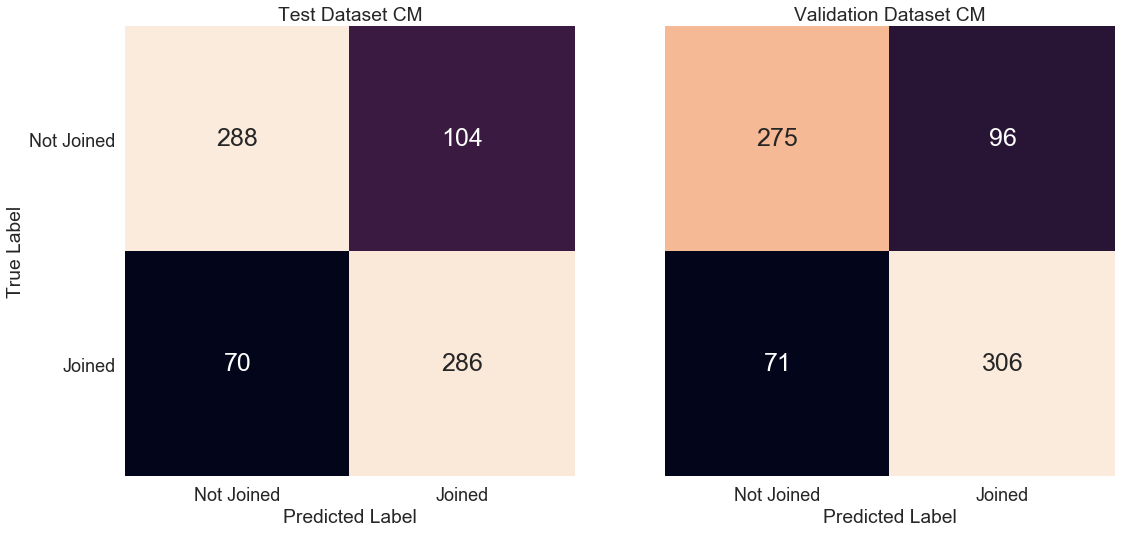

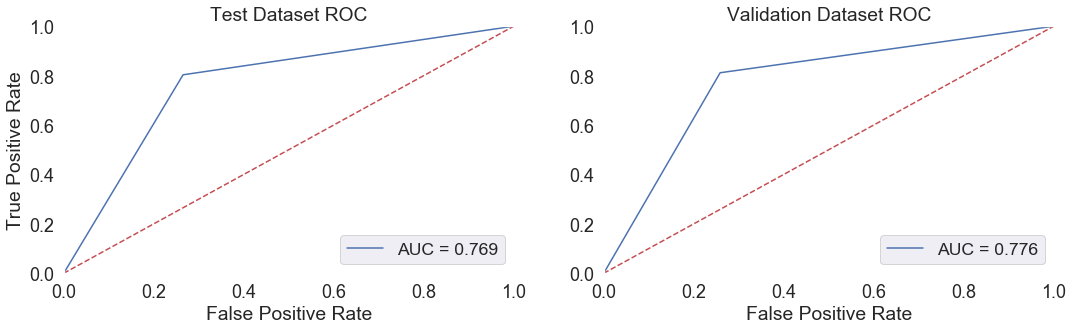

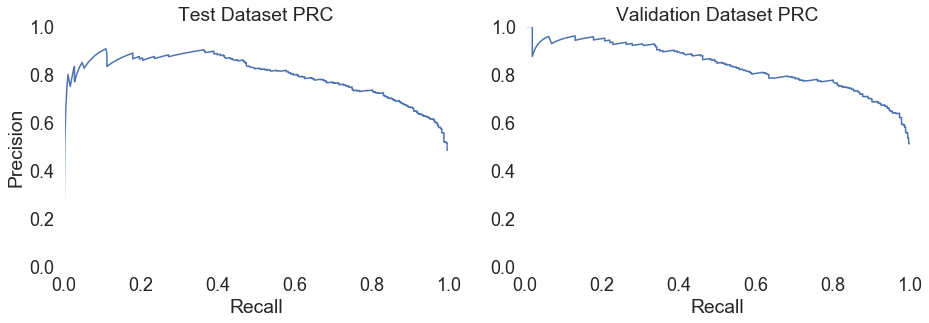

,Statistic,Test dataset value,Validation dataset value
0,Accuracy,0.76738,0.776738
1,Precision,0.733333,0.761194
2,Recall,0.803371,0.811671
3,F1 Score,0.766756,0.785623


In [38]:
# Set confusion matrices' figure and text size.
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 25, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test Dataset.
#==========================================
# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#==========================================

# Validation Dataset.
#==========================================
# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=[], square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set plot and text sizes.
plt.figure(figsize=(10,10))
plt.rcParams.update({'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test ROC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(2,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#==========================================

# Validation ROC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(2,2,2, fc='white')

# Set title.
plt.title('Validation Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set PRC figure and text sizes.
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test PRC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(3,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset PRC')

# Plot the precision-recall curve.
plt.plot(test_rec, test_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('Precision')
plt.xlabel('Recall')
#==========================================

# Validation PRC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(3,2,2, fc='white')

# Set title.
plt.title('Validation Dataset PRC')

# Plot the precision-recall curve.
plt.plot(valid_rec, valid_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('Recall')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()
#==========================================

# Print statistics.
stats_df.style.set_table_styles(dfstyle)

# Stochastic Gradient Descent model.

In [39]:
# Create Stochastic Gradient Descent model, fit the model to the training data.
model = SGDClassifier(random_state = 99, max_iter=1000, tol=1e-3, loss='log')
model = model.fit(X_train, y_train)

In [40]:
# Get predictions for the testing data.
test_preds = model.predict(X_test)

# Get predictions for the validation data.
valid_preds = model.predict(X_validation)

# Plot descriptive graphs and statistics.

### General statistics (Accuracy, Precision, Recall, F1 Score).

In [41]:
# Useful statistics
test_accuracy = metrics.accuracy_score(y_test, test_preds)
test_precision = metrics.precision_score(y_test, test_preds)
test_recall = metrics.recall_score(y_test, test_preds)
test_f1_score = metrics.f1_score(y_test, test_preds)

test_stats_list = [test_accuracy, test_precision, test_recall, test_f1_score]

In [42]:
# Useful statistics
valid_accuracy = metrics.accuracy_score(y_validation, valid_preds)
valid_precision = metrics.precision_score(y_validation, valid_preds)
valid_recall = metrics.recall_score(y_validation, valid_preds)
valid_f1_score = metrics.f1_score(y_validation, valid_preds)

valid_stats_list = [valid_accuracy, valid_precision, valid_recall, valid_f1_score]

In [43]:
stat_names_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Dataframe for all statistics.
stats_df = pd.DataFrame()
stats_df['Statistic'] = stat_names_list
stats_df['Test dataset value'] = test_stats_list
stats_df['Validation dataset value'] = valid_stats_list

### Confusion Matrices.

In [44]:
test_cm = metrics.confusion_matrix(y_test, test_preds)
valid_cm = metrics.confusion_matrix(y_validation, valid_preds)

### Receiver Operating Characteristics.

In [45]:
# Test dataset.
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, test_preds)
test_auc = metrics.auc(test_fpr, test_tpr)

In [46]:
# Validation dataset.
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_validation, valid_preds)
valid_auc = metrics.auc(valid_fpr, valid_tpr)

### Precision-Recall curves.

In [47]:
# Get churned probability on test predictions.
test_probs_rows = model.predict_proba(X_test)
test_probs = [test_probs_rows[i][1] for i in range(len(test_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
test_prec, test_rec, test_thresholds = metrics.precision_recall_curve(y_test, test_probs)

In [48]:
# Get churned probability on validation predictions.
valid_probs_rows = model.predict_proba(X_validation)
valid_probs = [valid_probs_rows[i][1] for i in range(len(valid_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
valid_prec, valid_rec, valid_thresholds = metrics.precision_recall_curve(y_validation, valid_probs)

## Plot graphs and statistics.

In [49]:
# Set dataframe print properties.
heading_properties = [('font-size', '28px')]
cell_properties = [('font-size', '28px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [50]:
# Set the tickmark names.
classNames = ['Not Joined','Joined']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

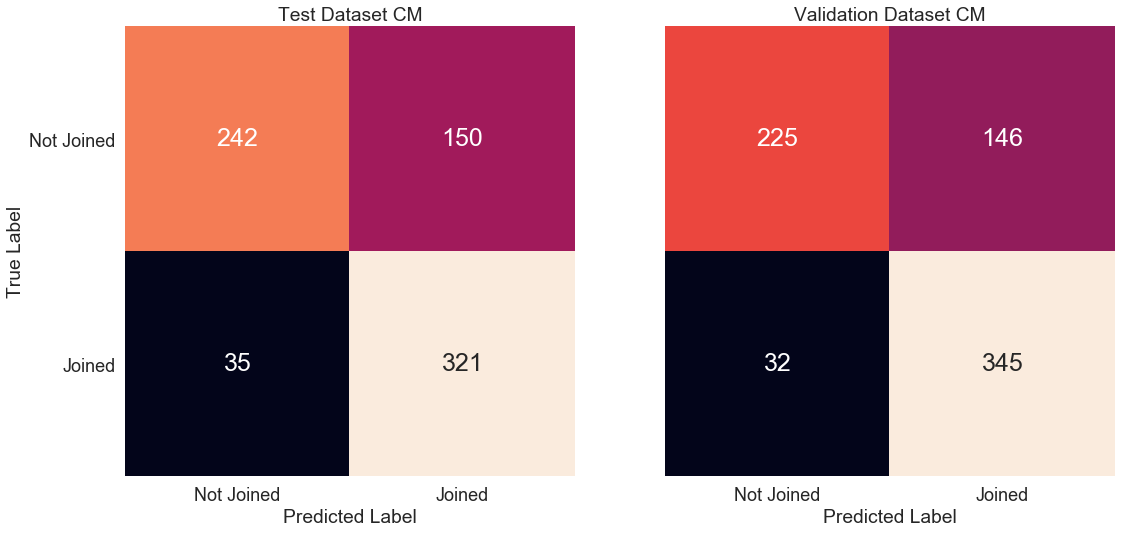

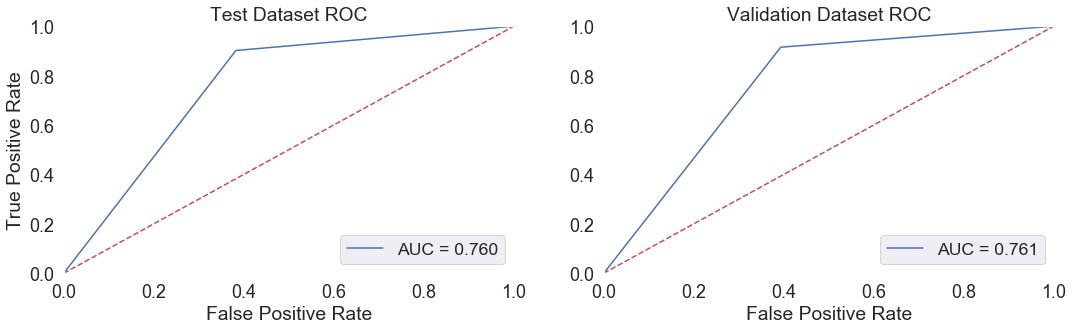

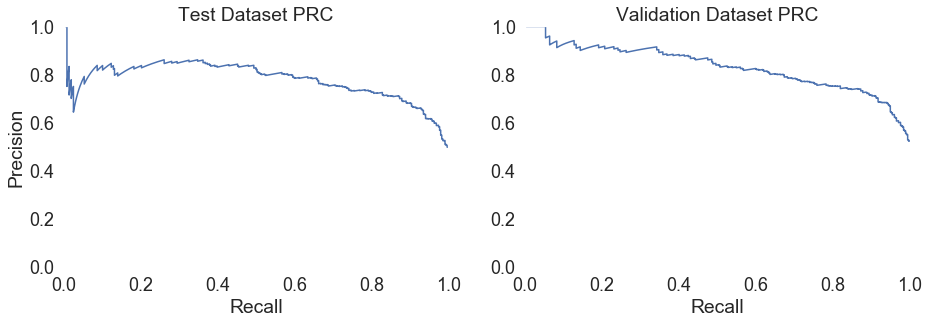

,Statistic,Test dataset value,Validation dataset value
0,Accuracy,0.752674,0.762032
1,Precision,0.681529,0.702648
2,Recall,0.901685,0.915119
3,F1 Score,0.7763,0.794931


In [51]:
# Set confusion matrices' figure and text size.
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 25, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test Dataset.
#==========================================
# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#==========================================

# Validation Dataset.
#==========================================
# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=[], square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set plot and text sizes.
plt.figure(figsize=(10,10))
plt.rcParams.update({'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test ROC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(2,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#==========================================

# Validation ROC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(2,2,2, fc='white')

# Set title.
plt.title('Validation Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set PRC figure and text sizes.
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test PRC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(3,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset PRC')

# Plot the precision-recall curve.
plt.plot(test_rec, test_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('Precision')
plt.xlabel('Recall')
#==========================================

# Validation PRC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(3,2,2, fc='white')

# Set title.
plt.title('Validation Dataset PRC')

# Plot the precision-recall curve.
plt.plot(valid_rec, valid_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('Recall')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()
#==========================================

# Print statistics.
stats_df.style.set_table_styles(dfstyle)

# Neural Network model.

In [52]:
# Create Neural Network model, fit the model to the training data.
model = MLPClassifier(random_state = 99, max_iter=1000)
model = model.fit(X_train, y_train)

In [53]:
# Get predictions for the testing data.
test_preds = model.predict(X_test)

# Get predictions for the validation data.
valid_preds = model.predict(X_validation)

# Plot descriptive graphs and statistics.

### General statistics (Accuracy, Precision, Recall, F1 Score).

In [54]:
# Useful statistics
test_accuracy = metrics.accuracy_score(y_test, test_preds)
test_precision = metrics.precision_score(y_test, test_preds)
test_recall = metrics.recall_score(y_test, test_preds)
test_f1_score = metrics.f1_score(y_test, test_preds)

test_stats_list = [test_accuracy, test_precision, test_recall, test_f1_score]

In [55]:
# Useful statistics
valid_accuracy = metrics.accuracy_score(y_validation, valid_preds)
valid_precision = metrics.precision_score(y_validation, valid_preds)
valid_recall = metrics.recall_score(y_validation, valid_preds)
valid_f1_score = metrics.f1_score(y_validation, valid_preds)

valid_stats_list = [valid_accuracy, valid_precision, valid_recall, valid_f1_score]

In [56]:
stat_names_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Dataframe for all statistics.
stats_df = pd.DataFrame()
stats_df['Statistic'] = stat_names_list
stats_df['Test dataset value'] = test_stats_list
stats_df['Validation dataset value'] = valid_stats_list

### Confusion Matrices.

In [57]:
test_cm = metrics.confusion_matrix(y_test, test_preds)
valid_cm = metrics.confusion_matrix(y_validation, valid_preds)

### Receiver Operating Characteristics.

In [58]:
# Test dataset.
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, test_preds)
test_auc = metrics.auc(test_fpr, test_tpr)

In [59]:
# Validation dataset.
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_validation, valid_preds)
valid_auc = metrics.auc(valid_fpr, valid_tpr)

### Precision-Recall curves.

In [60]:
# Get churned probability on test predictions.
test_probs_rows = model.predict_proba(X_test)
test_probs = [test_probs_rows[i][1] for i in range(len(test_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
test_prec, test_rec, test_thresholds = metrics.precision_recall_curve(y_test, test_probs)

In [61]:
# Get churned probability on validation predictions.
valid_probs_rows = model.predict_proba(X_validation)
valid_probs = [valid_probs_rows[i][1] for i in range(len(valid_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
valid_prec, valid_rec, valid_thresholds = metrics.precision_recall_curve(y_validation, valid_probs)

## Plot graphs and statistics.

In [62]:
# Set dataframe print properties.
heading_properties = [('font-size', '28px')]
cell_properties = [('font-size', '28px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [63]:
# Set the tickmark names.
classNames = ['Not Joined','Joined']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

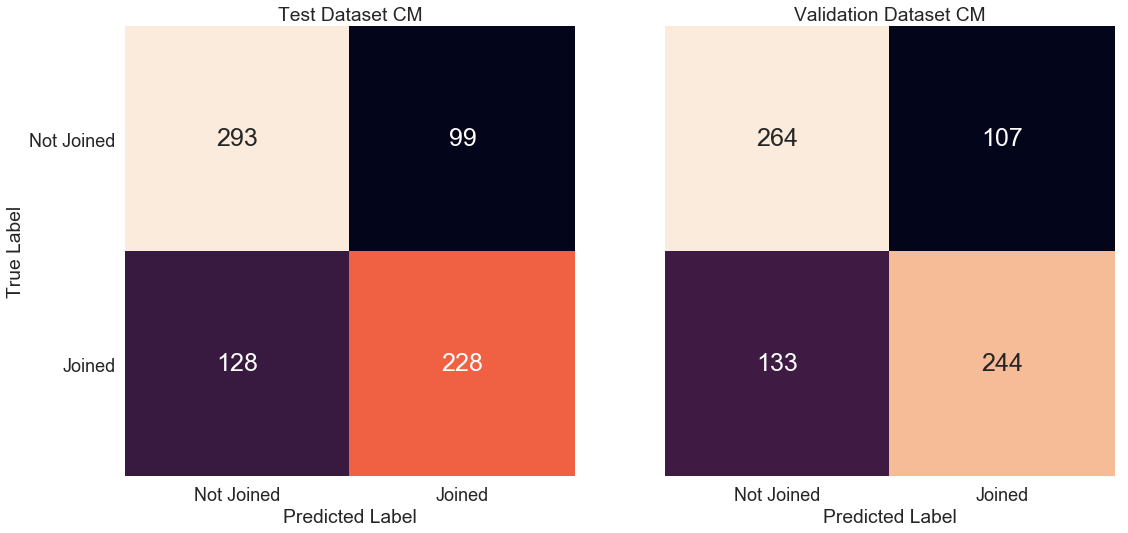

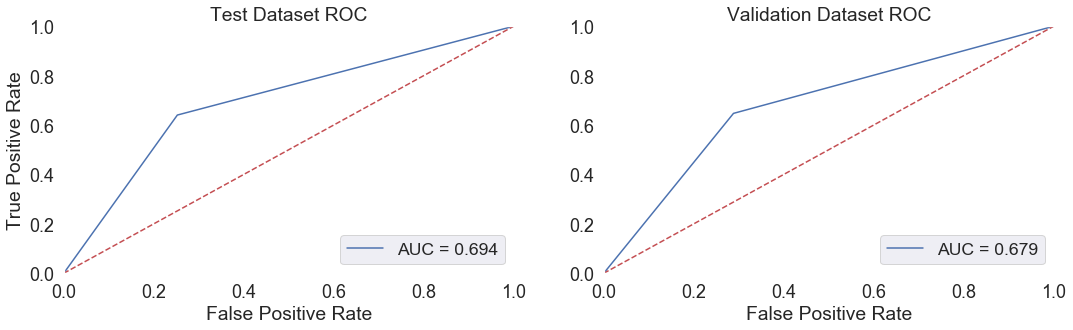

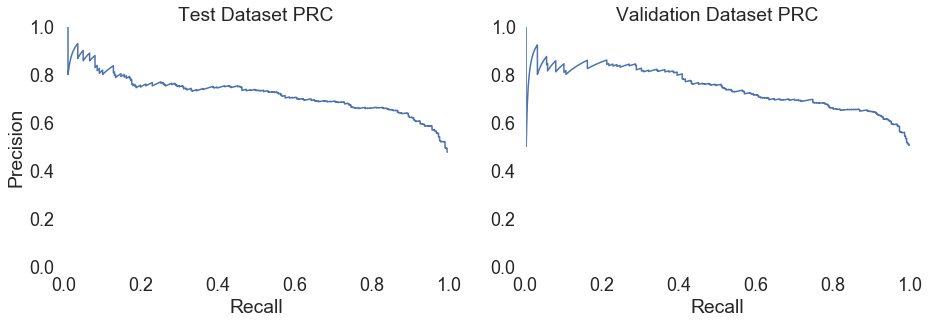

,Statistic,Test dataset value,Validation dataset value
0,Accuracy,0.696524,0.679144
1,Precision,0.697248,0.695157
2,Recall,0.640449,0.647215
3,F1 Score,0.667643,0.67033


In [64]:
# Set confusion matrices' figure and text size.
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 25, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test Dataset.
#==========================================
# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#==========================================

# Validation Dataset.
#==========================================
# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=[], square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set plot and text sizes.
plt.figure(figsize=(10,10))
plt.rcParams.update({'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test ROC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(2,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#==========================================

# Validation ROC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(2,2,2, fc='white')

# Set title.
plt.title('Validation Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set PRC figure and text sizes.
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test PRC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(3,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset PRC')

# Plot the precision-recall curve.
plt.plot(test_rec, test_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('Precision')
plt.xlabel('Recall')
#==========================================

# Validation PRC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(3,2,2, fc='white')

# Set title.
plt.title('Validation Dataset PRC')

# Plot the precision-recall curve.
plt.plot(valid_rec, valid_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('Recall')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()
#==========================================

# Print statistics.
stats_df.style.set_table_styles(dfstyle)

# Linear SVM model.

In [65]:
# Create Linear SVM model, fit the model to the training data.
model = LinearSVC(random_state = 99)
model = CalibratedClassifierCV(model, cv=5)
model = model.fit(X_train, y_train)

In [66]:
# Get predictions for the testing data.
test_preds = model.predict(X_test)

# Get predictions for the validation data.
valid_preds = model.predict(X_validation)

# Plot descriptive graphs and statistics.

### General statistics (Accuracy, Precision, Recall, F1 Score).

In [67]:
# Useful statistics
test_accuracy = metrics.accuracy_score(y_test, test_preds)
test_precision = metrics.precision_score(y_test, test_preds)
test_recall = metrics.recall_score(y_test, test_preds)
test_f1_score = metrics.f1_score(y_test, test_preds)

test_stats_list = [test_accuracy, test_precision, test_recall, test_f1_score]

In [68]:
# Useful statistics
valid_accuracy = metrics.accuracy_score(y_validation, valid_preds)
valid_precision = metrics.precision_score(y_validation, valid_preds)
valid_recall = metrics.recall_score(y_validation, valid_preds)
valid_f1_score = metrics.f1_score(y_validation, valid_preds)

valid_stats_list = [valid_accuracy, valid_precision, valid_recall, valid_f1_score]

In [69]:
stat_names_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Dataframe for all statistics.
stats_df = pd.DataFrame()
stats_df['Statistic'] = stat_names_list
stats_df['Test dataset value'] = test_stats_list
stats_df['Validation dataset value'] = valid_stats_list

### Confusion Matrices.

In [70]:
test_cm = metrics.confusion_matrix(y_test, test_preds)
valid_cm = metrics.confusion_matrix(y_validation, valid_preds)

### Receiver Operating Characteristics.

In [71]:
# Test dataset.
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, test_preds)
test_auc = metrics.auc(test_fpr, test_tpr)

In [72]:
# Validation dataset.
valid_fpr, valid_tpr, valid_thresholds = metrics.roc_curve(y_validation, valid_preds)
valid_auc = metrics.auc(valid_fpr, valid_tpr)

### Precision-Recall curves.

In [73]:
# Get churned probability on test predictions.
test_probs_rows = model.predict_proba(X_test)
test_probs = [test_probs_rows[i][1] for i in range(len(test_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
test_prec, test_rec, test_thresholds = metrics.precision_recall_curve(y_test, test_probs)

In [74]:
# Get churned probability on validation predictions.
valid_probs_rows = model.predict_proba(X_validation)
valid_probs = [valid_probs_rows[i][1] for i in range(len(valid_probs_rows))]

# Calculate precision, recall, and thresholds for both datasets.
valid_prec, valid_rec, valid_thresholds = metrics.precision_recall_curve(y_validation, valid_probs)

## Plot graphs and statistics.

In [75]:
# Set dataframe print properties.
heading_properties = [('font-size', '28px')]
cell_properties = [('font-size', '28px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

In [76]:
# Set the tickmark names.
classNames = ['Not Joined','Joined']

# Set the text scale for Seaborn.
sb.set(font_scale=1.6)

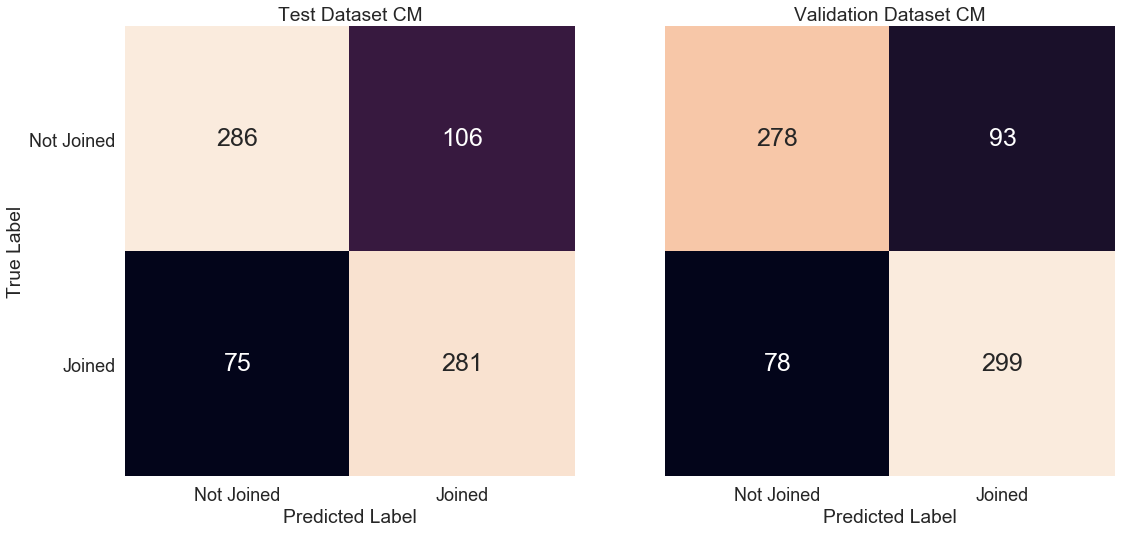

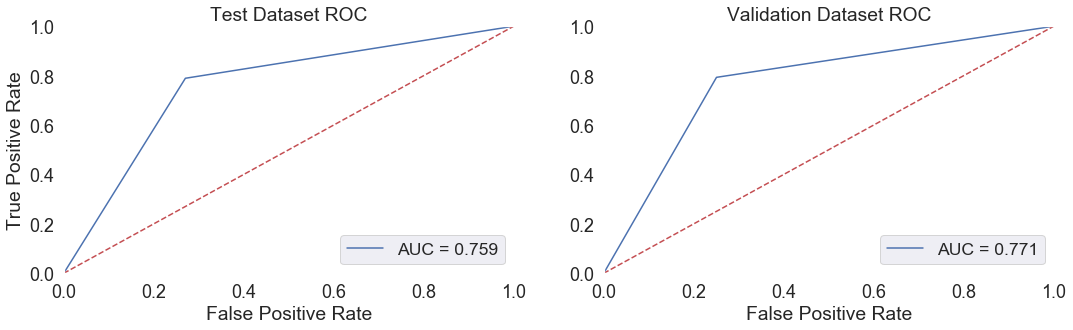

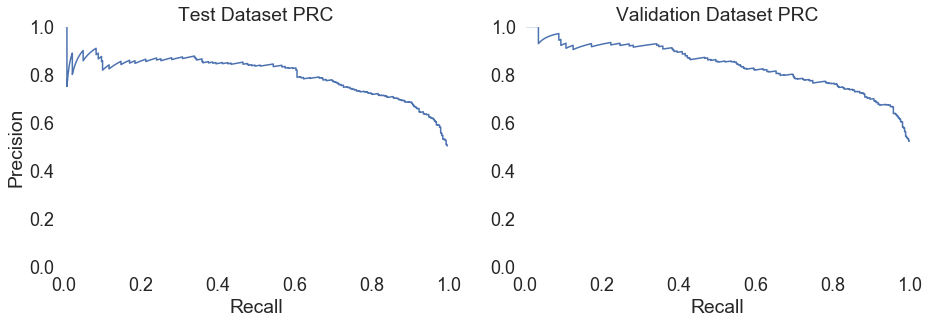

,Statistic,Test dataset value,Validation dataset value
0,Accuracy,0.758021,0.77139
1,Precision,0.726098,0.762755
2,Recall,0.789326,0.793103
3,F1 Score,0.756393,0.777633


In [77]:
# Set confusion matrices' figure and text size.
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 25, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test Dataset.
#==========================================
# Create first subplot.
plt.subplot(1,2,1)

# Set title.
plt.title('Test Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(test_cm, annot=np.array(test_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=classNames, square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x and y axes names.
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
#==========================================

# Validation Dataset.
#==========================================
# Create second subplot.
plt.subplot(1,2,2)

# Set title.
plt.title('Validation Dataset CM')

# Create confusion matrix as a Seaborn heatmap.
sb.heatmap(valid_cm, annot=np.array(valid_cm), fmt='d', cbar=False, xticklabels=classNames, yticklabels=[], square=True)

# Set y tick-label rotation angle.
plt.yticks(rotation=0)

# Set x axis name.
plt.xlabel('Predicted Label')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set plot and text sizes.
plt.figure(figsize=(10,10))
plt.rcParams.update({'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test ROC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(2,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(test_fpr, test_tpr, 'b', label = 'AUC = %0.3f' % test_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#==========================================

# Validation ROC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(2,2,2, fc='white')

# Set title.
plt.title('Validation Dataset ROC')

# Plot the data, fpr = x, tpr = y. Bold, with a label for the AUC.
plt.plot(valid_fpr, valid_tpr, 'b', label = 'AUC = %0.3f' % valid_auc)

# Place legend on plot.
plt.legend(loc = 'lower right')

# Plot a dotted red straight line for comparison
plt.plot([0, 1], [0, 1],'r--')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('False Positive Rate')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.5)

plt.show()
#==========================================

# Set PRC figure and text sizes.
plt.figure(figsize=(10,15))
plt.rcParams.update({'font.size': 13, 'xtick.labelsize' : 18, 'ytick.labelsize' : 18})

# Test PRC curve
#==========================================
# Create first subplot with a white background.
plt.subplot(3,2,1, fc='white')

# ax = plt.axes()
# ax.set_facecolor('white')

# Set title.
plt.title('Test Dataset PRC')

# Plot the precision-recall curve.
plt.plot(test_rec, test_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label axes.
plt.ylabel('Precision')
plt.xlabel('Recall')
#==========================================

# Validation PRC curve
#==========================================
# Create second subplot with a white background.
plt.subplot(3,2,2, fc='white')

# Set title.
plt.title('Validation Dataset PRC')

# Plot the precision-recall curve.
plt.plot(valid_rec, valid_prec, 'b')

# Set x and y boundaries.
plt.xlim([0, 1])
plt.ylim([0, 1])

# Label x axis.
plt.xlabel('Recall')

# Adjust distance from the right edge of each subplot.
plt.subplots_adjust(right=1.3)

plt.show()
#==========================================

# Print statistics.
stats_df.style.set_table_styles(dfstyle)

In [78]:
duration = 1000  # milliseconds
freq = 1000  # Hz

In [79]:
sound.Beep(freq, duration)